In [17]:
from dsa2000_common.common.enu_frame import ENU
import numpy as np
from dsa2000_cal.assets.content_registry import fill_registries
from dsa2000_cal.assets.registries import array_registry
import networkx as nx

import astropy.time as at
import astropy.units as au
import astropy.coordinates as ac
import pylab as plt

fill_registries()
array = array_registry.get_instance(array_registry.get_match('dsa2000_optimal_v1'))
antennas = array.get_antennas()
ref_time = at.Time.now()

array_location = array.get_array_location()

antennas_enu_xyz = antennas.get_itrs(obstime=ref_time, location=array_location).transform_to(ENU(obstime=ref_time, location=array_location)).cartesian.xyz.T.to('km').value

Searching for sync certificate: /home/albert/git/DSA2000-Cal/dsa2000_cal/src/dsa2000_cal/assets/arrays/dsa2000_optimal_v1/.sync_cert


In [36]:
from scipy.spatial import KDTree

G = nx.Graph()

tree = KDTree(antennas_enu_xyz)
k = 5
nn_dists, nn_idxs = tree.query(antennas_enu_xyz, k=k+1)
nn_idxs = nn_idxs[:, 1:]
nn_dists = nn_dists[:, 1:]

for i in range(antennas_enu_xyz.shape[0]):
    for dist, j in zip(nn_dists[i], nn_idxs[i]):
        G.add_edge(i, int(j), weight=float(dist))



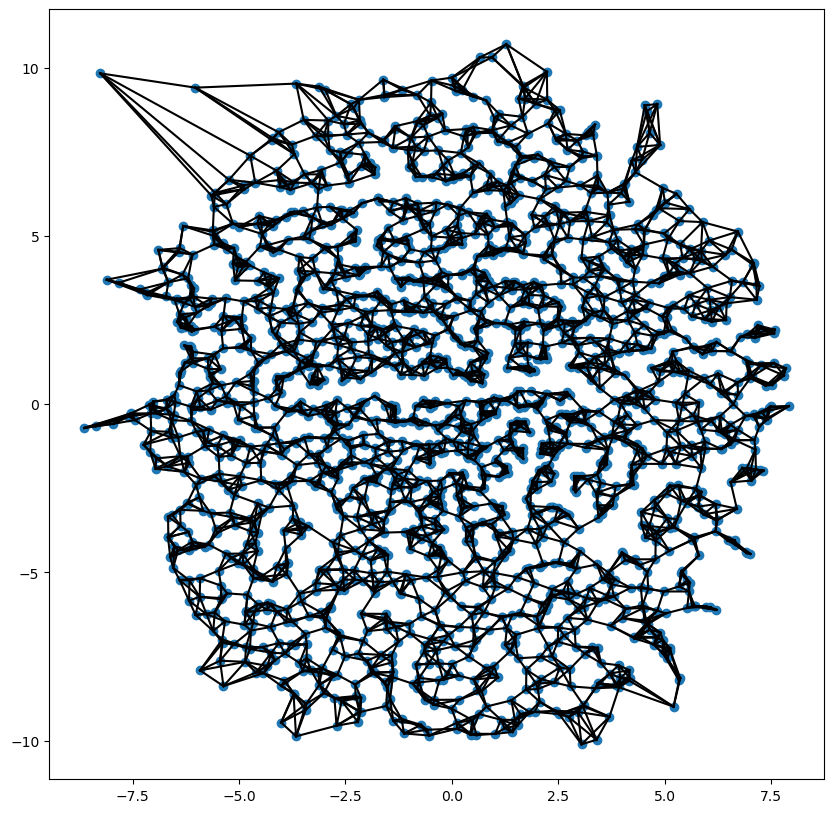

In [41]:

# plot graph
plt.figure(figsize=(10, 10))
plt.scatter(antennas_enu_xyz[:,0], antennas_enu_xyz[:,1])
# for i in range(antennas_enu_xyz.shape[0]):
#     plt.text(antennas_enu_xyz[i,0], antennas_enu_xyz[i,1], str(i))
for i, j in G.edges():
    plt.plot([antennas_enu_xyz[i,0], antennas_enu_xyz[j,0]], [antennas_enu_xyz[i,1], antennas_enu_xyz[j,1]], 'k-')
plt.show()

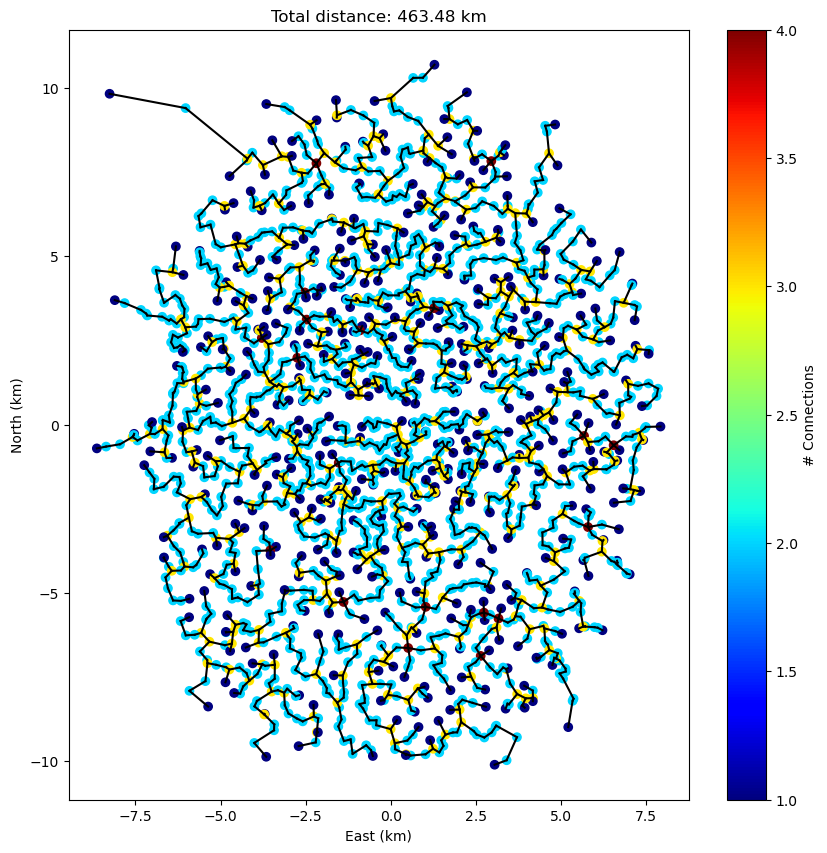

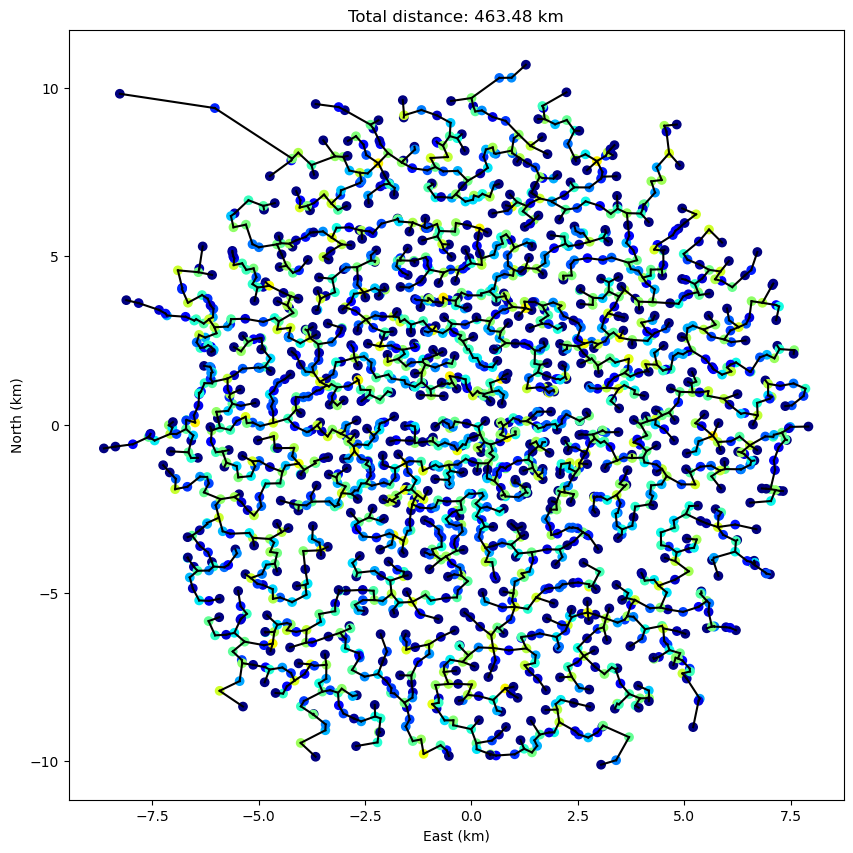

In [42]:

T = nx.minimum_spanning_tree(G, algorithm='kruskal', weight='weight')

total_distance = sum([T.edges[i, j]['weight'] for i, j in T.edges()])

# Plot the tree
# Nodes are colored by their degree
plt.figure(figsize=(10, 10))
sc = plt.scatter(antennas_enu_xyz[:,0], antennas_enu_xyz[:,1], c=[T.degree[i] for i in range(antennas_enu_xyz.shape[0])], cmap='jet')
plt.colorbar(sc, label='# Connections')

# for i in range(antennas_enu_xyz.shape[0]):
#     plt.text(antennas_enu_xyz[i,0], antennas_enu_xyz[i,1], str(i))
for i, j in T.edges():
    plt.plot([antennas_enu_xyz[i,0], antennas_enu_xyz[j,0]], [antennas_enu_xyz[i,1], antennas_enu_xyz[j,1]], 'k-')

plt.title(f'Total distance: {total_distance:.2f} km')
plt.xlabel('East (km)')
plt.ylabel('North (km)')
plt.show()

# Plot the tree
# For each node compute the maximum angle between edges that connect to it
def compute_max_angle(n):
    angles = []
    for i in T.neighbors(n):
        for j in T.neighbors(n):
            if i != j:
                a = antennas_enu_xyz[n] - antennas_enu_xyz[i]
                b = antennas_enu_xyz[n] - antennas_enu_xyz[j]
                cos_angle = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
                angles.append(np.pi - np.arccos(cos_angle))
    if len(angles) > 0:
        return np.max(angles)*180/np.pi
    else:
        return 0
node_angles = [compute_max_angle(n) for n in range(antennas_enu_xyz.shape[0])]

plt.figure(figsize=(10, 10))
sc = plt.scatter(antennas_enu_xyz[:,0], antennas_enu_xyz[:,1], c=node_angles, cmap='jet',vmin=0, vmax=180)
# plt.colorbar(sc, label='#Maximal angle (deg)')

# for i in range(antennas_enu_xyz.shape[0]):
#     plt.text(antennas_enu_xyz[i,0], antennas_enu_xyz[i,1], str(i))
for i, j in T.edges():
    plt.plot([antennas_enu_xyz[i,0], antennas_enu_xyz[j,0]], [antennas_enu_xyz[i,1], antennas_enu_xyz[j,1]], 'k-')

plt.title(f'Total distance: {total_distance:.2f} km')
plt.xlabel('East (km)')
plt.ylabel('North (km)')
plt.show()

In [40]:
print(np.percentile(node_angles, 50))

41.80503323301559
